In [1]:
%load_ext autoreload
%autoreload 2

# Segway Model with Motor damping

We can approximate the motor damping by (in steady state with no load)：

$$
UI = T_{damp} \omega
$$

There should be a term $IR$ in the equation, but we fear that $R$ might not be constant, so we ignore it over here by keeping I small. The data we collected are 
$$
\begin{array}{c|c|c}
U & I & \omega \\
\hline
0 & 0 & 0 \\
\end{array}
$$

## Analysis

Hopefully, we can assume that $T_{damp} \approx B \omega + B_0 sign(M)$, where $B$ and $B_0$ are constants. The term with sign function $B_0 sign(M)= B_0 \frac{M}{|M|}$ here should account for the initial friction. Then we can plug them in the right hand side of the equation as an additional non-conservative generalized force.

First for $\omega$, it should be the same on both side of the wheel, (Since we directly minus it from the torque $M$, we don't need to consider the sign as $\omega$ will always have the same sign as $M$), in our model, $\omega =(\varphi - \gamma)'=\frac{\dot{x}_C}{R} -\dot{\gamma}$

 The equations of motion are then:

$$
\begin{align}
 (m + m_w ) \ddot{x}_C + m h \ddot{\gamma} \cos \gamma - m h \dot{\gamma}^2 \sin \gamma &= \frac{(M - T_{damp})}{R} , \\
m h \ddot{x}_C \cos \gamma + (m h^2 + I) \ddot{\gamma} - m g h \sin \gamma &= - (M - T_{damp}).
\end{align}
$$

To save some trouble and make it more accurate, we will not linearize the equations, but directly use them in the nonlinear form to get equation of $\ddot{x}_C$ and $\ddot{\gamma}$. But we still need to seperate $\ddot{x}_C$ and $\ddot{\gamma}$ from the equations, let's keep the $N(q)$ notation in the nonlinear model. Skipping the details of the algebra, we can get the following equations:

$$
\begin{align}\ddot{x} &= N_{11} \left(\frac{(M - T_{damp})}{R} + m h \dot{\gamma}^2 \sin \gamma\right) + N_{12} \left(-(M - T_{damp}) + m g h \sin \gamma\right), \\
\ddot{\gamma} &= N_{21} \left(\frac{(M - T_{damp})}{R} + m h \dot{\gamma}^2 \sin \gamma\right) + N_{22} \left(-(M - T_{damp}) + m g h \sin \gamma\right).
\end{align}
$$

Where:
$$
\begin{align}
N(q) = \begin{bmatrix}m + m_w & m h \cos \gamma \\
m h \cos \gamma & m h^2 + I\end{bmatrix}^{-1}. \\
T_{damp} = B \omega + B_0 sign(\omega) = B \left(\frac{\dot{x}_C}{R} -\dot{\gamma}\right) + B_0 sign\left(\frac{\dot{x}_C}{R} -\dot{\gamma}\right).
\end{align}
$$




## Simulation

- Balance Mode:

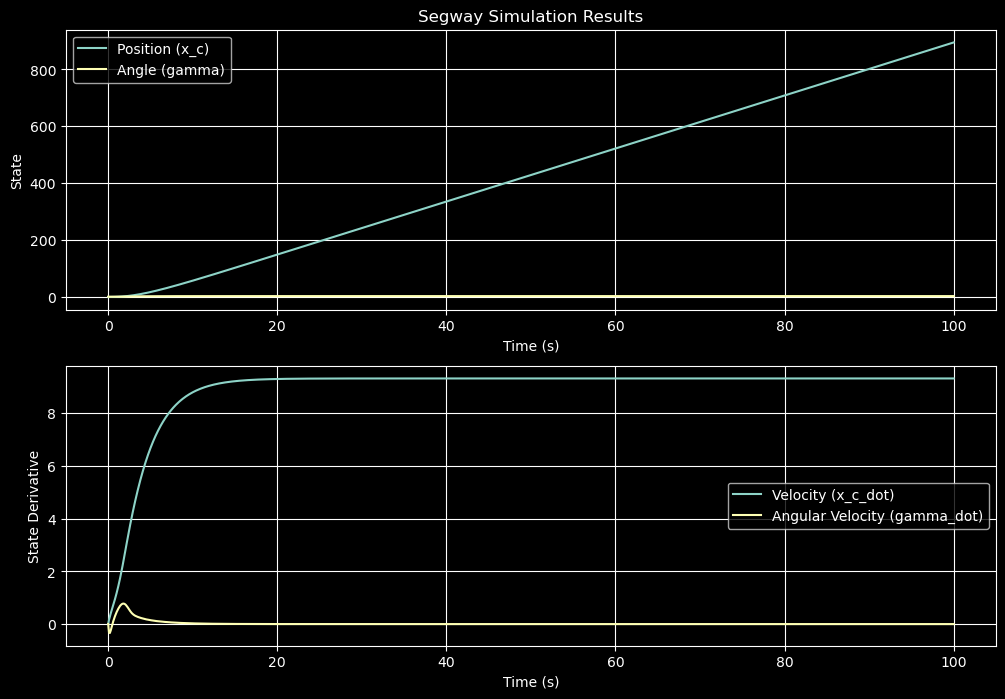

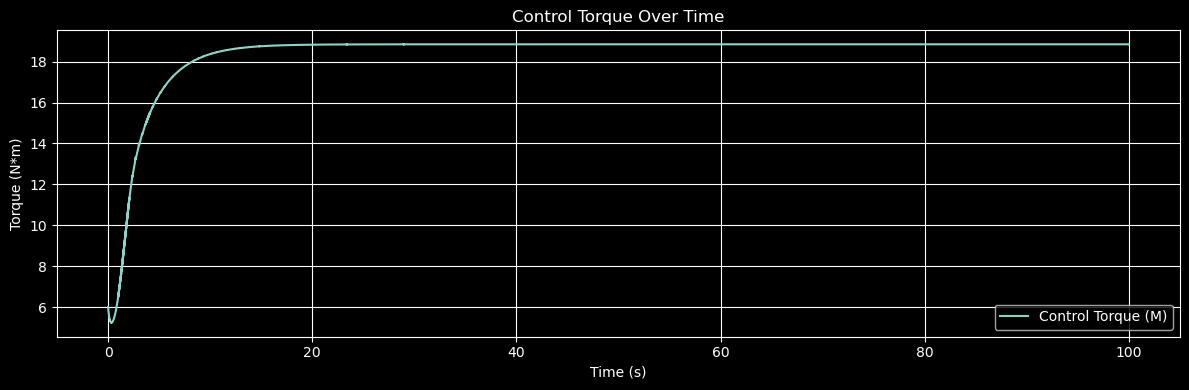

In [ ]:
from Runner import run_simulation
from Parameters import params
from Config import CONTROL_MODE, MODEL_T

params.K_gamma = 6.0
params.K_dgamma = 1.0

run_simulation(
    initial_state=[0.0, 0.0, 1, 0.0],
    time_span=(0, 100),
    control_mode=CONTROL_MODE.BALANCE,
    desired_gamma=0.0,
    model_type=MODEL_T.NONLINEAR_DAMP,
    record_Torque=True
)

- Velocity Mode:

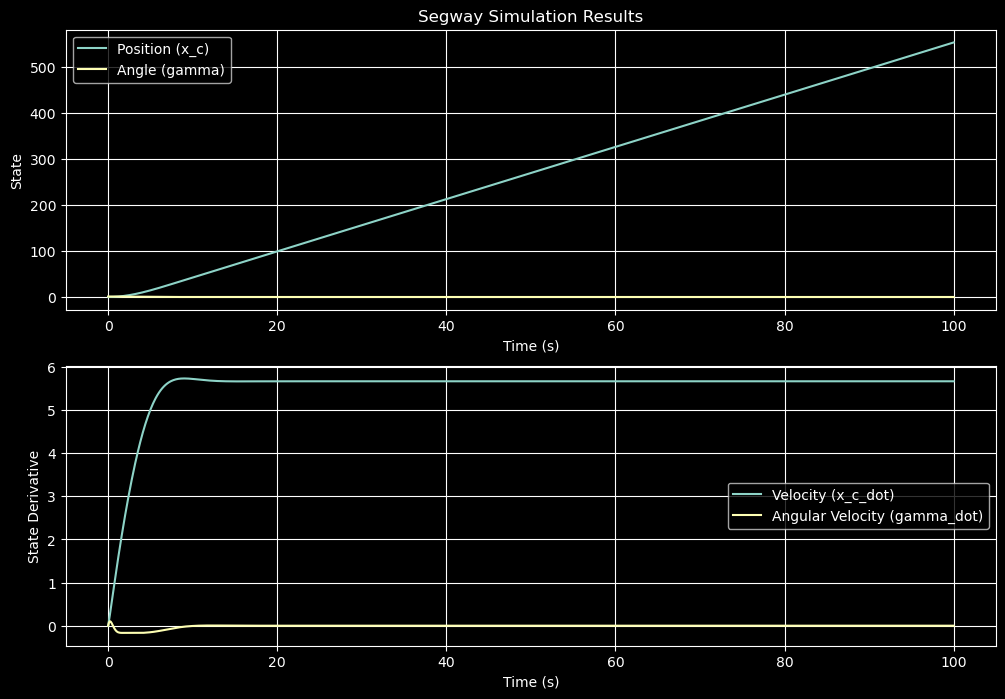

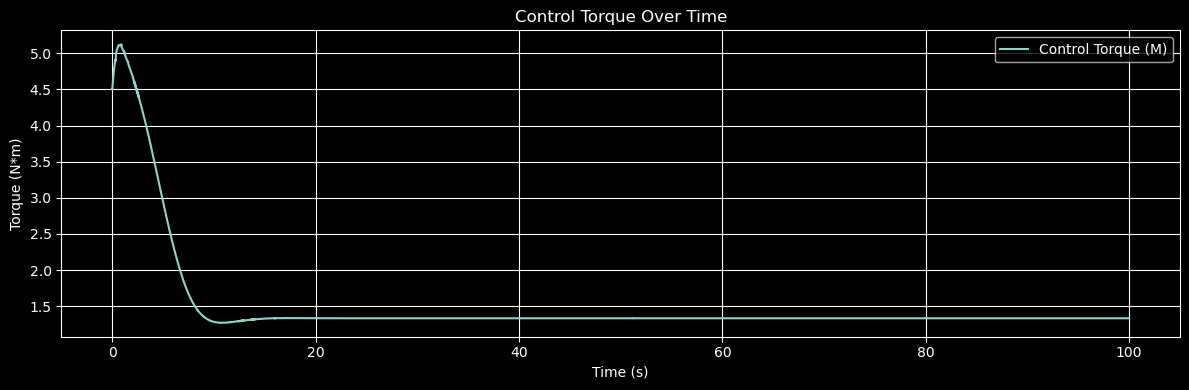

In [20]:
from Runner import run_simulation
from Parameters import params
from Config import CONTROL_MODE, MODEL_T

params.K_gamma = 6.0
params.K_dgamma = 1.0
params.K_velocity = 0.5 # tuned larger in compansation of the friction damping

run_simulation(
    initial_state=[0.0, 0.0, 1, 0.0],
    time_span=(0, 100),
    control_mode=CONTROL_MODE.VELOCITY,
    desired_gamma=0.0,
    desired_velocity=3.0,
    model_type=MODEL_T.NONLINEAR_DAMP,
    record_Torque=True,
)

- Postion Mode:


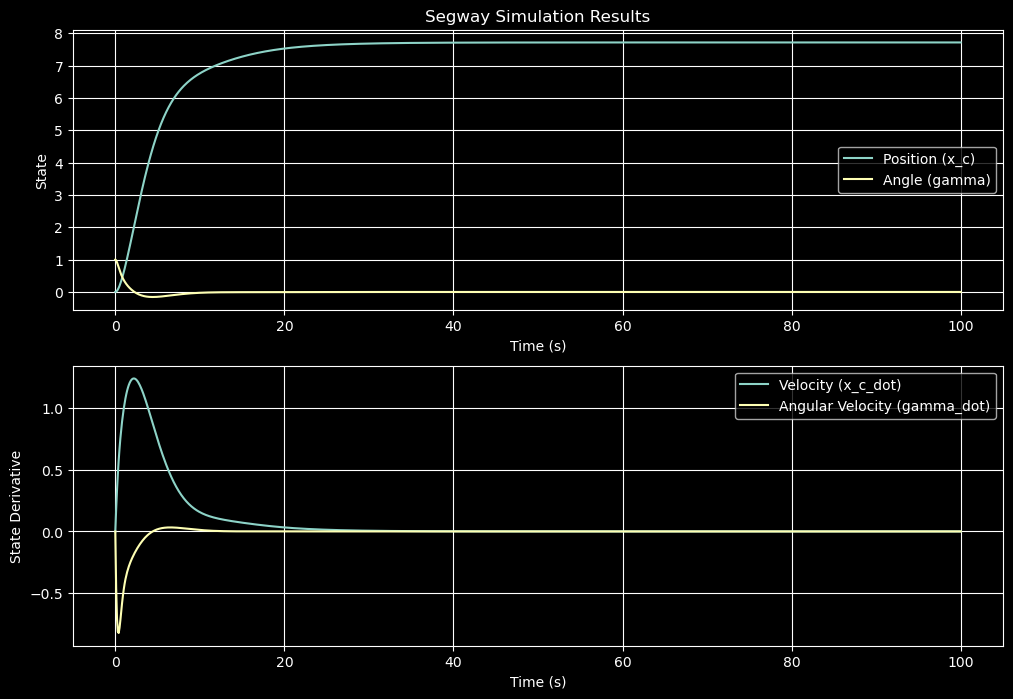

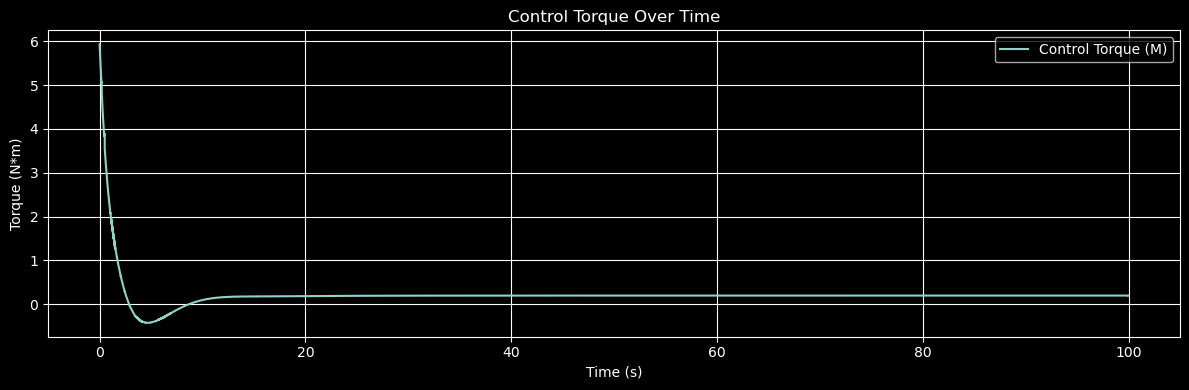

In [ ]:
from Runner import run_simulation
from Parameters import params
from Config import CONTROL_MODE, MODEL_T

params.K_gamma = 6.0
params.K_dgamma = 1.0
params.K_velocity = 0.5 # tuned larger to get stable position control
params.K_position = 0.035

run_simulation(
    initial_state=[0.0, 0.0, 1, 0.0],
    time_span=(0, 100),
    control_mode=CONTROL_MODE.POSITION,
    desired_gamma=0.0,
    desired_velocity=0.0,
    desired_position=2.0,
    model_type=MODEL_T.NONLINEAR_DAMP,
    record_Torque=True,
)

# Futher analysis

While the control is smooth, we can see that the error is large. Mainly when the torque becomes too small to be equal to the friction, the system will be stuck at a velocity or a position that is not the desired one. To solve this, we can add a integral term to the control, which can help to eliminate the steady state error.

For velocity control:
$$
M = K_\gamma (\gamma - \gamma_d) + K_{\dot{\gamma}} (\dot{\gamma} - \dot{\gamma}_d) + K_v (v - v_d) + K_{vi} \int (v - v_d) dt
$$  

For position control:
$$
M = K_\gamma (\gamma - \gamma_d) + K_{\dot{\gamma}} (\dot{\gamma} - \dot{\gamma}_d) + K_v (v - v_d) + K_{vi} \int (v - v_d) dt + K_p (x - x_d) + K_{pi} \int (x - x_d) dt
$$

- Velocity mode:

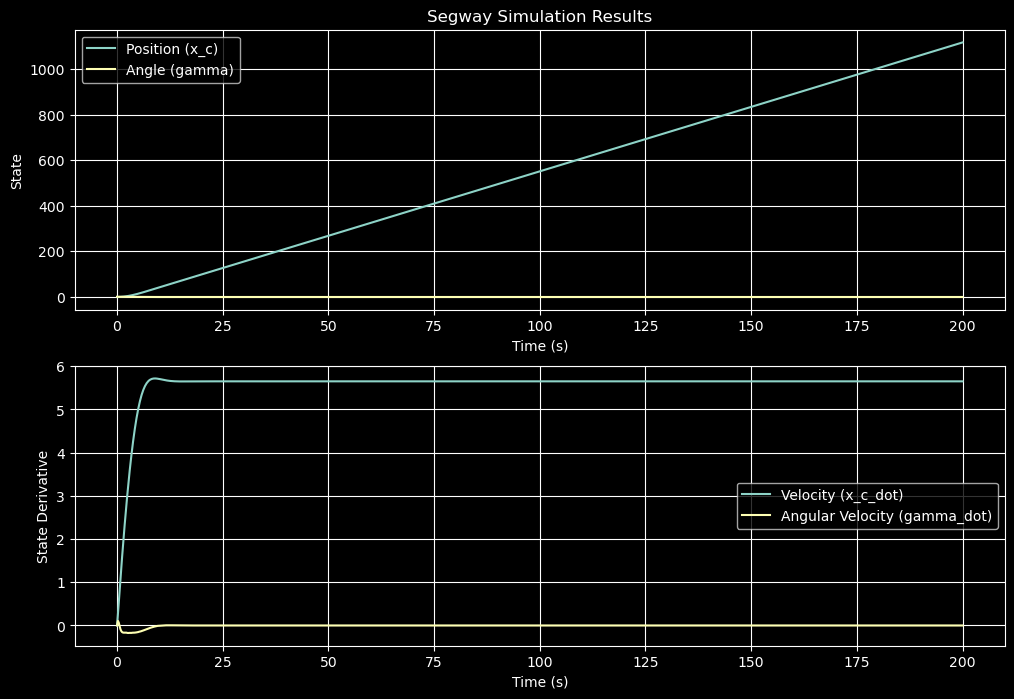

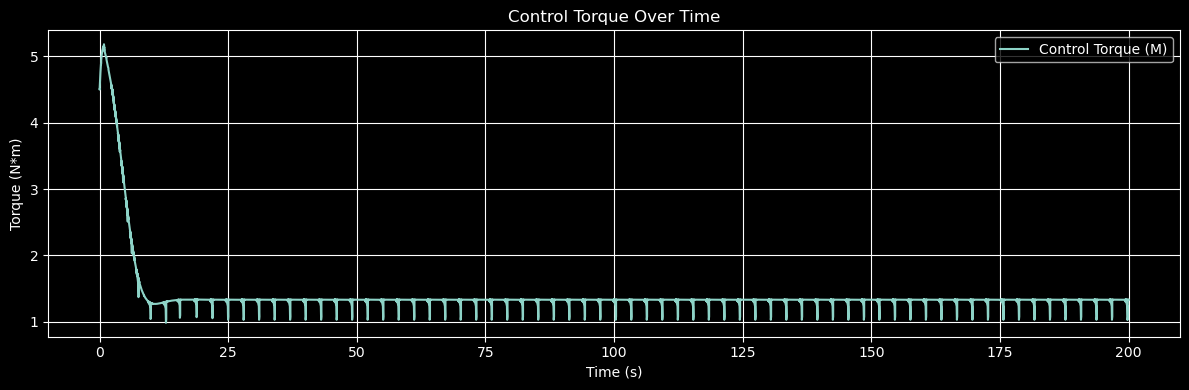

In [41]:
from Runner import run_simulation
from Parameters import params
from Config import CONTROL_MODE, MODEL_T, CONTROL_STRATEGY

params.K_gamma = 6.0
params.K_dgamma = 1.0
params.K_velocity = 0.5 # tuned larger in compansation of the friction damping
params.K_vi = 0.05

run_simulation(
    initial_state=[0.0, 0.0, 1, 0.0],
    time_span=(0, 200),
    control_mode=CONTROL_MODE.VELOCITY,
    controller_type=CONTROL_STRATEGY.PID,
    desired_gamma=0.0,
    desired_velocity=3.0,
    model_type=MODEL_T.NONLINEAR_DAMP,
    record_Torque=True,
)

- Position mode:

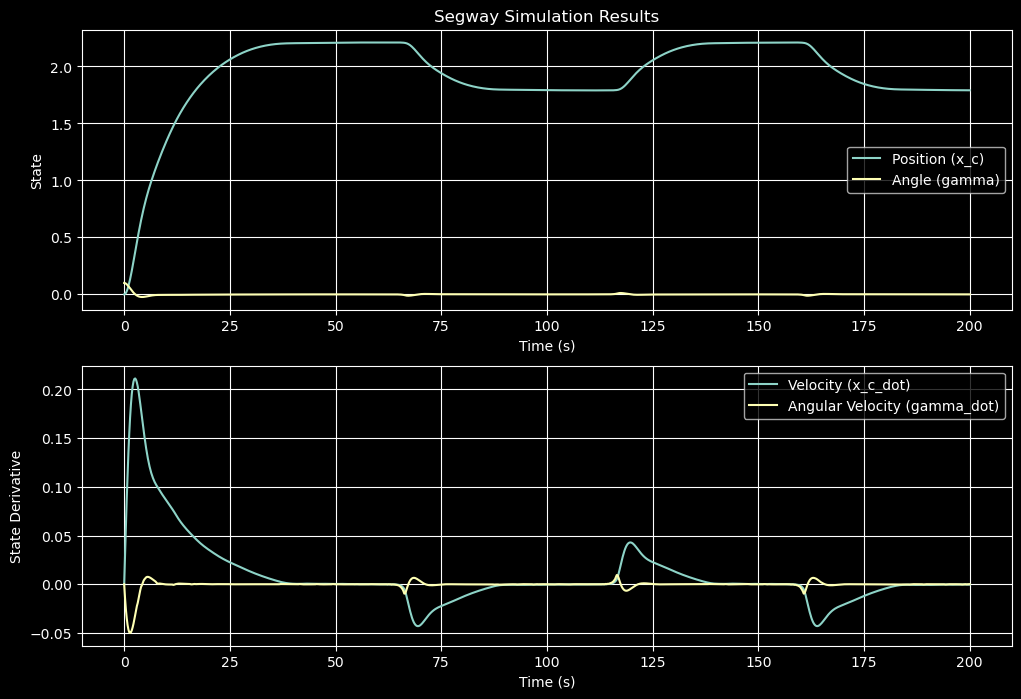

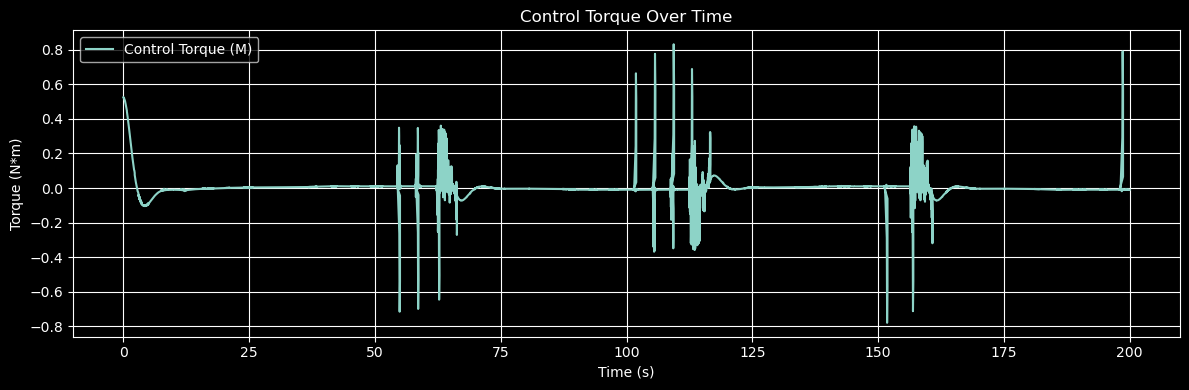

In [111]:
from Runner import run_simulation
from Parameters import params
from Config import CONTROL_MODE, MODEL_T, CONTROL_STRATEGY

params.K_gamma = 6.0
params.K_dgamma = 1.0
params.K_velocity = 0.5
params.K_position = 0.038
params.K_vi = 0
params.K_pi = 0.002
params.posDeadZone = 0.05
params.clip_integral = 1.0

# May be the damping is too large for K_position, we can try to reduce the damping to get better position control performance
params.B = 0.01
params.B_0 = 0.01


run_simulation(
    initial_state=[0.0, 0.0, 0.1, 0.0],
    time_span=(0, 200),
    control_mode=CONTROL_MODE.POSITION,
    controller_type=CONTROL_STRATEGY.PID,
    desired_gamma=0.0,
    desired_velocity=0.0,
    desired_position=2.0,
    model_type=MODEL_T.NONLINEAR_DAMP,
    record_Torque=True,
)